In [1]:
import tensorflow as tf

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
# # Organize data into train, valid, test dirs
# os.chdir('F:\Allen\Python\Keras\DeepLizard\CNN\data\dogs-vs-cats')
# if os.path.isdir('train/dog') is False:
#     os.makedirs('train/dog')
#     os.makedirs('train/cat')
#     os.makedirs('valid/dog')
#     os.makedirs('valid/cat')
#     os.makedirs('test/dog')
#     os.makedirs('test/cat')

#     for i in random.sample(glob.glob('cat*'), 500):
#         shutil.move(i, 'train/cat')      
#     for i in random.sample(glob.glob('dog*'), 500):
#         shutil.move(i, 'train/dog')
#     for i in random.sample(glob.glob('cat*'), 100):
#         shutil.move(i, 'valid/cat')        
#     for i in random.sample(glob.glob('dog*'), 100):
#         shutil.move(i, 'valid/dog')
#     for i in random.sample(glob.glob('cat*'), 50):
#         shutil.move(i, 'test/cat')      
#     for i in random.sample(glob.glob('dog*'), 50):
#         shutil.move(i, 'test/dog')

# os.chdir('../../')

In [4]:
train_path = 'data/dogs-vs-cats/train'
valid_path = 'data/dogs-vs-cats/valid'
test_path = 'data/dogs-vs-cats/test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [7]:
imgs, labels = next(train_batches)

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

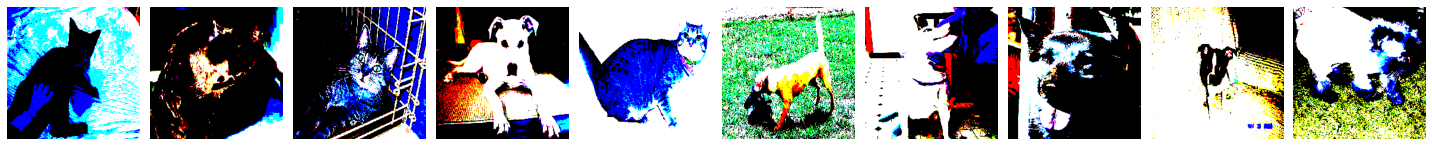

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [9]:
plotImages(imgs)
print(labels)

***Directory Iterator*** is an infinitely repeating dataset. (It will continue to generate *batches* to us as long as we want it to.

* When using a *Directory Iterator* we need to specify another parameter to the fit function: `steps_per_epoch`  

`steps_per_epoch` Total number of steps (batches of samples) to yield from our training set before declaring one epoch finished during the training process.  

> Typically equivalent to: No. of samples in our training set / Batch Size

`model.fit` would run infinitely if `steps_per_epoch` is not defined.  

*DeepLizard playlist videos will not contain the* `steps_per_epoch`, *must be included*

* If we are passing **validation data** to the `fit` function. We must also specify `validation_steps` (Acts in the same way as `steps_per_epoch` but for **validation data** instead of **training data**.  


* When we call `model.predict`, we need to specify the `steps` parameter. (Same as `steps_per_epoch`, but when using for predictions, it is the **Number of batches to yield from the test set before declaring the prediction round finished.**

## Build And Train A CNN

In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape = (224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    
    # the general choice of having more filters in later layers than in earlier ones is common
    Conv2D(filters=64, kernel_size = (3, 3), activation='relu', padding="same"),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

Now that the model is built, we need to **compile** the model.  

When we have only two classes, we could configure our output, we can use `binary_crossentropy` as **loss** instead of `categorical_crossentropy`. (Both work equally well and achieve the exact same result).  

With `binary_crossentropy`, the last layer should use `sigmoid`, rather than `softmax`, as its **activation function**.

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

Specify `steps_per_epoch` to indicate how many batches of samples from our training set should be passed to the model before declaring **one epoch complete**.  

Since we have 1000 samples in our **training set**, and our **batch size** is 10, then we set `steps_per_epoch` to be 100

In [13]:
model.fit(x=train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches, validation_steps=len(valid_batches), epochs=10, verbose=2)

Epoch 1/10
100/100 - 47s - loss: 18.0496 - accuracy: 0.5690 - val_loss: 3.7006 - val_accuracy: 0.6800
Epoch 2/10
100/100 - 49s - loss: 2.9164 - accuracy: 0.7460 - val_loss: 2.8392 - val_accuracy: 0.7100
Epoch 3/10
100/100 - 52s - loss: 0.8525 - accuracy: 0.8660 - val_loss: 4.2011 - val_accuracy: 0.6000
Epoch 4/10
100/100 - 51s - loss: 0.1593 - accuracy: 0.9530 - val_loss: 2.7785 - val_accuracy: 0.6650
Epoch 5/10
100/100 - 56s - loss: 0.0233 - accuracy: 0.9900 - val_loss: 2.9385 - val_accuracy: 0.6650
Epoch 6/10
100/100 - 49s - loss: 0.0139 - accuracy: 0.9950 - val_loss: 2.7488 - val_accuracy: 0.6700
Epoch 7/10
100/100 - 51s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.5731 - val_accuracy: 0.6450
Epoch 8/10
100/100 - 44s - loss: 5.2526e-04 - accuracy: 1.0000 - val_loss: 2.5673 - val_accuracy: 0.6650
Epoch 9/10
100/100 - 49s - loss: 3.8020e-04 - accuracy: 1.0000 - val_loss: 2.5611 - val_accuracy: 0.6600
Epoch 10/10
100/100 - 53s - loss: 3.2970e-04 - accuracy: 1.0000 - val_loss: 2.5573

> *Training Accuracy* has reached **100%**  
> *Validation Accuracy* is only at **71%**  
>
> Some **overfitting** going on. (Model is not generalizing well)  
> Will not perform well on **Test Set**, can expect accuracy similar to *Validation Accuracy*

## CNN Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

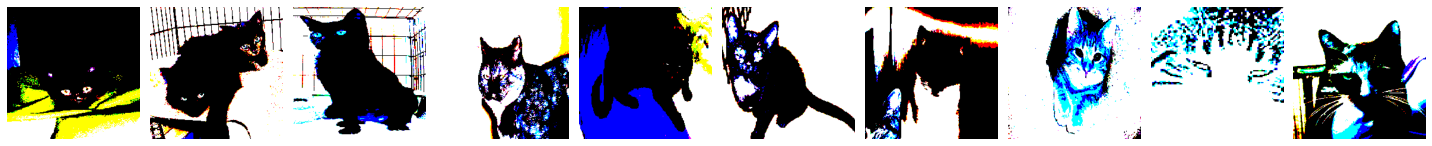

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [14]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

We specified for `test_batches`, `shuffle` = **False**

In [15]:
type(test_batches)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [16]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

`verbose=0` will show you nothing (silent)  

`verbose=1` will show you an animated progress bar like this:

$$[===================================]$$

`verbose=2` will just mention the number of epoch like this:

             Epoch 1/10

In [17]:
predictions = model.predict(x=test_batches, steps = len(test_batches), verbose=0) #We want no output.

DID NOT SPECIFY `steps`

In [18]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.

We transform the one-hot encoded predicted labels to be in the same format as the true labels by only selecting the element with the highest value for each prediction using `np.argmax(predictions, axis=-1)`

In [19]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

##### Plot Confusion Matrix

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Inspect the `class_indices` for the *labels* so that we know in which order to pass them to our **confusion matrix**.

In [21]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[35 15]
 [22 28]]


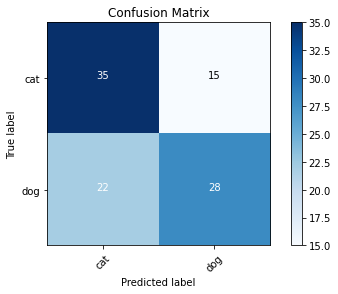

In [22]:
cm_plot_labels = ["cat", "dog"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix");

Model is definitely **overfitting**.

## Build Fine-tuned VGG16 model

In [23]:
# Download model - Internet Connection needed
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [24]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Output layer of `vgg16` model has **1000** different outputs.  

We have to change last output layer to predict only **2 output classes** corresponding to *cat* and *dog*.  

______________________________________________

`type(vgg16_model)` output: tensorflow.python.keras.engine.`functional.Functional`  

Model is from `Functional` API

In [25]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

Converting original `vgg16` model into `Sequential` model.

In [26]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

The last layer has not been included in this model &#8595;

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

Iterate over each layer in Sequential model and set them to be non-trainable. 

> Freezes weights and other trainable parameters in each layer so that they will not be trained or updated when we later pass our images of cats and dogs.

In [28]:
for layer in model.layers:
    layer.trainable = False

In [29]:
model.count_params()

134260544

In [30]:
# Code copied from stackoverflow

import tensorflow.keras.backend as K

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 134,260,544.0
Trainable params: 0.0
Non-trainable params: 134,260,544


In [31]:
model.add(Dense(units=2, activation='softmax'))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [33]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

`epochs` = 5 instead of 10

In [34]:
model.fit(x=train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches, validation_steps=len(valid_batches), epochs=5, verbose=2)

Epoch 1/5
100/100 - 184s - loss: 0.2327 - accuracy: 0.9100 - val_loss: 0.0612 - val_accuracy: 0.9850
Epoch 2/5
100/100 - 204s - loss: 0.0790 - accuracy: 0.9740 - val_loss: 0.0407 - val_accuracy: 0.9900
Epoch 3/5
100/100 - 185s - loss: 0.0544 - accuracy: 0.9800 - val_loss: 0.0323 - val_accuracy: 0.9900
Epoch 4/5
100/100 - 183s - loss: 0.0416 - accuracy: 0.9870 - val_loss: 0.0290 - val_accuracy: 0.9850
Epoch 5/5
100/100 - 187s - loss: 0.0327 - accuracy: 0.9890 - val_loss: 0.0267 - val_accuracy: 0.9900


### Predict using fine-tuned VGG16 model

In [35]:
predictions = model.predict(x=test_batches, verbose=0)

In [36]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [37]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

In [39]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

Confusion matrix, without normalization
[[49  1]
 [ 4 46]]


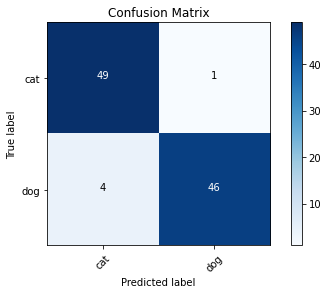

In [40]:
cm_plot_labels = ["cat", "dog"]
plot_confusion_matrix(cm = cm, classes=cm_plot_labels, title="Confusion Matrix")